# Fig.12 EyerissV2 Single-PE Reproduction

Reproduces fig12 (EyerissV2 single-PE) from the micro22-sparseloop-artifact using AccelForge.

**Workload:** MobileNet0.5-sparse, 8 layers (1x1 pointwise convolutions)
**Architecture:** BackingStorage (DRAM) → iact_spad / weight_spad / psum_spad → reg → MAC
**Sparse formats:** UOP+RLE with explicit per-rank flattened_rank_ids
**Distribution:** uniform_only (hypergeometric density model)

In [1]:
import os
import sys
import tempfile

import yaml
import pandas as pd

# Add accelforge to path
REPO_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.insert(0, REPO_ROOT)

from accelforge.frontend.spec import Spec
from accelforge.model.main import evaluate_mapping

FIG12_DIR = os.path.join(REPO_ROOT, 'tests', 'input_files', 'fig12')
print(f'Using configs from: {FIG12_DIR}')

Using configs from: /home/fisherxue/65931S2026/accelforge/tests/input_files/fig12


## 1. Configuration Files

The EyerissV2 PE has a 6-level hierarchy with separate scratchpads for inputs, weights, and partial sums.

In [2]:
for name in ['arch.yaml', 'sparse_SI_SW.yaml']:
    with open(os.path.join(FIG12_DIR, name)) as f:
        print(f'=== {name} ===')
        print(f.read())
        print()

=== arch.yaml ===
# EyerissV2 single-PE architecture for fig12 reproduction.
# 6-level hierarchy: BackingStorage → iact_spad / weight_spad / psum_spad → reg → MAC
# ERT values from Accelergy (45nm, Aladdin_table + Cacti estimators).
# BackingStorage: 0 energy (DRAM boundary, not counted at PE level).
# psum_spad: single average energy 0.33633 pJ (Sparseloop uses data-delta-dependent).

arch:
  nodes:
  - !Memory
    name: BackingStorage
    size: 131072
    leak_power: 0
    area: 0
    total_latency: "0"
    tensors: {keep: ~Intermediates, may_keep: All}
    actions:
    - {name: read, energy: 0, bits_per_action: 64, latency: 0}
    - {name: write, energy: 0, bits_per_action: 64, latency: 0}
    - {name: metadata_read, energy: 0, bits_per_action: 8, latency: 0}
    - {name: metadata_write, energy: 0, bits_per_action: 8, latency: 0}

  - !Memory
    name: iact_spad
    size: 16
    leak_power: 0
    area: 0
    total_latency: "0"
    tensors: {keep: All}
    actions:
    - {name: read,

## 2. Layer Parameters

All 8 layers are 1x1 pointwise convolutions (R=1, S=1, N=1, G=1) with varying M, E, F, C dimensions and input/weight densities.

In [3]:
# Layer parameters from Sparseloop artifact (MobileNet0.5-sparse)
LAYERS = {
    'L07': {'M': 64,  'E': 32, 'F': 32, 'C': 64,  'd_I': 0.73, 'd_W': 0.52,
            'BS_M': 8,  'BS_C': 8,  'psum_M': 8,  'psum_C': 8},
    'L09': {'M': 128, 'E': 16, 'F': 16, 'C': 64,  'd_I': 0.86, 'd_W': 0.82,
            'BS_M': 8,  'BS_C': 8,  'psum_M': 16, 'psum_C': 8},
    'L13': {'M': 256, 'E': 8,  'F': 8,  'C': 128, 'd_I': 0.83, 'd_W': 0.64,
            'BS_M': 16, 'BS_C': 16, 'psum_M': 16, 'psum_C': 8},
    'L19': {'M': 256, 'E': 8,  'F': 8,  'C': 256, 'd_I': 0.61, 'd_W': 0.55,
            'BS_M': 16, 'BS_C': 32, 'psum_M': 16, 'psum_C': 8},
    'L21': {'M': 256, 'E': 8,  'F': 8,  'C': 256, 'd_I': 0.64, 'd_W': 0.60,
            'BS_M': 16, 'BS_C': 32, 'psum_M': 16, 'psum_C': 8},
    'L23': {'M': 256, 'E': 8,  'F': 8,  'C': 256, 'd_I': 0.61, 'd_W': 0.70,
            'BS_M': 16, 'BS_C': 32, 'psum_M': 16, 'psum_C': 8},
    'L25': {'M': 512, 'E': 4,  'F': 4,  'C': 256, 'd_I': 0.68, 'd_W': 0.65,
            'BS_M': 32, 'BS_C': 32, 'psum_M': 16, 'psum_C': 8},
    'L27': {'M': 512, 'E': 4,  'F': 4,  'C': 512, 'd_I': 0.58, 'd_W': 0.30,
            'BS_M': 32, 'BS_C': 64, 'psum_M': 16, 'psum_C': 8},
}

df_layers = pd.DataFrame(LAYERS).T
df_layers.index.name = 'Layer'
display(df_layers)

,M,E,F,C,d_I,d_W,BS_M,BS_C,psum_M,psum_C
Layer,,,,,,,,,,
L07,64.0,32.0,32.0,64.0,0.73,0.52,8.0,8.0,8.0,8.0
L09,128.0,16.0,16.0,64.0,0.86,0.82,8.0,8.0,16.0,8.0
L13,256.0,8.0,8.0,128.0,0.83,0.64,16.0,16.0,16.0,8.0
L19,256.0,8.0,8.0,256.0,0.61,0.55,16.0,32.0,16.0,8.0
L21,256.0,8.0,8.0,256.0,0.64,0.60,16.0,32.0,16.0,8.0
L23,256.0,8.0,8.0,256.0,0.61,0.70,16.0,32.0,16.0,8.0
L25,512.0,4.0,4.0,256.0,0.68,0.65,32.0,32.0,16.0,8.0
L27,512.0,4.0,4.0,512.0,0.58,0.30,32.0,64.0,16.0,8.0


## 3. Programmatic Config Generation

In [4]:
def make_workload_yaml(p):
    """Generate workload YAML string for a layer."""
    return f'''workload:
  iteration_space_shape:
    r: 0 <= r < 1
    s: 0 <= s < 1
    e: 0 <= e < {p['E']}
    f: 0 <= f < {p['F']}
    c: 0 <= c < {p['C']}
    m: 0 <= m < {p['M']}
    n: 0 <= n < 1
    g: 0 <= g < 1
  bits_per_value: {{~Outputs: 8, Outputs: 20}}
  einsums:
  - name: GroupedConv
    tensor_accesses:
    - name: Inputs
      projection: [n, c, g, e, f]
      density: {p['d_I']}
    - name: Weights
      projection: [c, m, g, r, s]
      density: {p['d_W']}
    - name: Outputs
      projection: [n, g, m, f, e]
      output: true
'''


def make_mapping_yaml(p):
    """Generate mapping YAML string for a layer.

    Mapping structure (top to bottom):
    - BackingStorage: all tensors
    - BS loops: M, C (outer), then weight_spad (Weights reuse across E,F)
    - BS loops: F, E (inner pixel iteration)
    - iact_spad (Inputs), psum_spad (Outputs)
    - psum loop: C inner
    - reg (Inputs, reused across M inner)
    - psum loop: M inner
    - Compute
    """
    M_inner = p['M'] // p['BS_M']
    C_inner = p['C'] // p['BS_C']
    return f'''mapping:
  nodes:
  - !Storage {{tensors: [Inputs, Weights, Outputs], component: BackingStorage}}
  - !Temporal {{rank_variable: m, tile_shape: {M_inner}}}
  - !Temporal {{rank_variable: c, tile_shape: {C_inner}}}
  - !Storage {{tensors: [Weights], component: weight_spad}}
  - !Temporal {{rank_variable: f, tile_shape: 1}}
  - !Temporal {{rank_variable: e, tile_shape: 1}}
  - !Storage {{tensors: [Inputs], component: iact_spad}}
  - !Storage {{tensors: [Outputs], component: psum_spad}}
  - !Temporal {{rank_variable: c, tile_shape: 1}}
  - !Storage {{tensors: [Inputs], component: reg}}
  - !Temporal {{rank_variable: m, tile_shape: 1}}
  - !Compute {{einsum: GroupedConv, component: MAC}}
'''

In [5]:
def run_layer(layer_name, layer_params):
    """Run a single layer through AccelForge and return results."""
    workload_yaml = make_workload_yaml(layer_params)
    mapping_yaml = make_mapping_yaml(layer_params)

    with tempfile.NamedTemporaryFile(mode='w', suffix='.yaml', delete=False) as wf:
        wf.write(workload_yaml)
        workload_path = wf.name
    with tempfile.NamedTemporaryFile(mode='w', suffix='.yaml', delete=False) as mf:
        mf.write(mapping_yaml)
        mapping_path = mf.name

    try:
        spec = Spec.from_yaml(
            os.path.join(FIG12_DIR, 'arch.yaml'),
            workload_path,
            mapping_path,
            os.path.join(FIG12_DIR, 'sparse_SI_SW.yaml'),
        )
        result = evaluate_mapping(spec)

        energy = float(result.data['Total<SEP>energy'].iloc[0])
        latency = float(result.data['Total<SEP>latency'].iloc[0])

        # Extract per-component energy
        comp_energy = {}
        for col in result.data.columns:
            if '<SEP>energy<SEP>' in col:
                parts = col.split('<SEP>')
                comp = parts[2]  # component name
                e = float(result.data[col].iloc[0])
                comp_energy[comp] = comp_energy.get(comp, 0.0) + e

        return {
            'energy_pJ': energy,
            'energy_uJ': energy / 1e6,
            'cycles': latency,
            'comp_energy': comp_energy,
            'result': result,
        }
    finally:
        os.unlink(workload_path)
        os.unlink(mapping_path)

## 4. Run L07 (Detailed Comparison)

In [6]:
# Run L07 using static YAML files
spec_L07 = Spec.from_yaml(
    os.path.join(FIG12_DIR, 'arch.yaml'),
    os.path.join(FIG12_DIR, 'workload_L07.yaml'),
    os.path.join(FIG12_DIR, 'mapping_L07.yaml'),
    os.path.join(FIG12_DIR, 'sparse_SI_SW.yaml'),
)
result_L07 = evaluate_mapping(spec_L07)

# Show all non-zero action counts
print('L07 Action Counts:')
for col in sorted(result_L07.data.columns):
    val = result_L07.data[col].iloc[0]
    if 'action' in col and val != 0 and 'format' not in col:
        name = col.replace('GroupedConv<SEP>action<SEP>', '')
        print(f'  {name}: {val:,.0f}')

L07 Action Counts:
  BackingStorage<SEP>Inputs<SEP>read: 47,841
  BackingStorage<SEP>Outputs<SEP>read: 143,360
  BackingStorage<SEP>Outputs<SEP>write: 163,840
  BackingStorage<SEP>Weights<SEP>read: 266
  BackingStorage<SEP>metadata_read: 192,496
  MAC<SEP>None<SEP>compute: 1,592,158
  MAC<SEP>skipped_compute: 2,602,146
  iact_spad<SEP>Inputs<SEP>read: 382,731
  iact_spad<SEP>Inputs<SEP>write: 382,731
  iact_spad<SEP>metadata_read: 385,024
  iact_spad<SEP>metadata_write: 385,024
  psum_spad<SEP>Outputs<SEP>read: 1,567,280
  psum_spad<SEP>Outputs<SEP>write: 2,050,910
  psum_spad<SEP>skipped_read: 2,561,488
  reg<SEP>Inputs<SEP>read: 3,061,842
  reg<SEP>Inputs<SEP>write: 382,731
  reg<SEP>metadata_read: 3,061,842
  reg<SEP>metadata_write: 382,731
  weight_spad<SEP>Weights<SEP>read: 1,592,158
  weight_spad<SEP>Weights<SEP>write: 2,130
  weight_spad<SEP>metadata_read: 1,680,384
  weight_spad<SEP>metadata_write: 1,641
  weight_spad<SEP>skipped_read: 1,132,462


In [7]:
# L07 per-component energy comparison
SL_L07 = {
    'MAC': 919355, 'reg': 372019, 'psum_spad': 1238919,
    'weight_spad': 2247877, 'iact_spad': 213850, 'BackingStorage': 0,
}

print(f'{"Component":>15} | {"AccelForge (pJ)":>15} | {"Sparseloop (pJ)":>15} | {"Delta %":>8}')
print('-' * 65)

af_total = 0
for comp in ['MAC', 'reg', 'psum_spad', 'weight_spad', 'iact_spad', 'BackingStorage']:
    af_e = 0
    for col in result_L07.data.columns:
        if f'energy<SEP>{comp}<SEP>' in col or f'energy<SEP>{comp}' in col:
            if '<SEP>energy<SEP>' in col:
                af_e += float(result_L07.data[col].iloc[0])
    af_total += af_e
    sl_e = SL_L07[comp]
    delta = ((af_e - sl_e) / sl_e * 100) if sl_e > 0 else 0
    print(f'{comp:>15} | {af_e:>15,.0f} | {sl_e:>15,.0f} | {delta:>+7.1f}%')

total_energy = float(result_L07.data['Total<SEP>energy'].iloc[0])
total_latency = float(result_L07.data['Total<SEP>latency'].iloc[0])
sl_total = sum(SL_L07.values())
sl_cycles = 1592245
print('-' * 65)
print(f'{"Total":>15} | {total_energy:>15,.0f} | {sl_total:>15,.0f} | {(total_energy-sl_total)/sl_total*100:>+7.1f}%')
print(f'{"Cycles":>15} | {total_latency:>15,.0f} | {sl_cycles:>15,.0f} | {(total_latency-sl_cycles)/sl_cycles*100:>+7.1f}%')

      Component | AccelForge (pJ) | Sparseloop (pJ) |  Delta %
-----------------------------------------------------------------
            MAC |         939,669 |         919,355 |    +2.2%
            reg |         372,014 |         372,019 |    -0.0%
      psum_spad |       1,216,906 |       1,238,919 |    -1.8%
    weight_spad |       2,247,832 |       2,247,877 |    -0.0%
      iact_spad |         214,532 |         213,850 |    +0.3%
 BackingStorage |               0 |               0 |    +0.0%
-----------------------------------------------------------------
          Total |       4,990,952 |       4,992,020 |    -0.0%
         Cycles |       1,592,158 |       1,592,245 |    -0.0%


## 5. Run All 8 Layers

In [8]:
# Sparseloop ground truth (uniform_only, exact pJ from stats files)
SL_GROUND_TRUTH = {
    'L07': {'cycles': 1592245, 'energy_pJ': 4992020},
    'L09': {'cycles': 1479114, 'energy_pJ': 3757580},
    'L13': {'cycles': 1114139, 'energy_pJ': 2996420},
    'L19': {'cycles': 1407304, 'energy_pJ': 4311730},
    'L21': {'cycles': 1610668, 'energy_pJ': 4764760},
    'L23': {'cycles': 1791135, 'energy_pJ': 5233700},
    'L25': {'cycles': 927185,  'energy_pJ': 2713340},
    'L27': {'cycles': 729915,  'energy_pJ': 2761280},
}

results = {}
for name, params in LAYERS.items():
    print(f'Running {name}...', end=' ')
    try:
        results[name] = run_layer(name, params)
        print(f'OK (energy={results[name]["energy_uJ"]:.2f} uJ, cycles={results[name]["cycles"]:,.0f})')
    except Exception as e:
        print(f'FAILED: {e}')
        results[name] = None

Running L07... OK (energy=4.99 uJ, cycles=1,592,158)
Running L09... 

OK (energy=3.78 uJ, cycles=1,478,912)
Running L13... OK (energy=3.01 uJ, cycles=1,114,007)
Running L19... 

OK (energy=4.33 uJ, cycles=1,407,189)
Running L21... OK (energy=4.79 uJ, cycles=1,610,613)
Running L23... 

OK (energy=5.27 uJ, cycles=1,790,968)
Running L25... 

OK (energy=2.73 uJ, cycles=926,941)
Running L27... OK (energy=2.76 uJ, cycles=729,809)


In [9]:
# Comparison table
rows = []
for name in LAYERS:
    sl = SL_GROUND_TRUTH[name]
    af = results.get(name)
    if af is None:
        rows.append({
            'Layer': name, 'AF Cycles': 'FAILED', 'SL Cycles': sl['cycles'],
            'AF Energy (uJ)': 'FAILED', 'SL Energy (uJ)': f"{sl['energy_pJ']/1e6:.2f}",
        })
        continue
    sl_energy_uJ = sl['energy_pJ'] / 1e6
    rows.append({
        'Layer': name,
        'AF Cycles': f"{af['cycles']:,.0f}",
        'SL Cycles': f"{sl['cycles']:,}",
        'Cycle Delta': f"{(af['cycles'] - sl['cycles']) / sl['cycles'] * 100:+.1f}%",
        'AF Energy (uJ)': f"{af['energy_uJ']:.2f}",
        'SL Energy (uJ)': f"{sl_energy_uJ:.2f}",
        'Energy Delta': f"{(af['energy_uJ'] - sl_energy_uJ) / sl_energy_uJ * 100:+.1f}%",
    })

df_comparison = pd.DataFrame(rows)
display(df_comparison)

,Layer,AF Cycles,SL Cycles,Cycle Delta,AF Energy (uJ),SL Energy (uJ),Energy Delta
0,L07,"1,592,158","1,592,245",-0.0%,4.99,4.99,-0.0%
1,L09,"1,478,912","1,479,114",-0.0%,3.78,3.76,+0.5%
2,L13,"1,114,007","1,114,139",-0.0%,3.01,3.00,+0.4%
3,L19,"1,407,189","1,407,304",-0.0%,4.33,4.31,+0.4%
4,L21,"1,610,613","1,610,668",-0.0%,4.79,4.76,+0.5%
5,L23,"1,790,968","1,791,135",-0.0%,5.27,5.23,+0.6%
6,L25,"926,941","927,185",-0.0%,2.73,2.71,+0.5%
7,L27,"729,809","729,915",-0.0%,2.76,2.76,-0.2%


## 6. Energy Breakdown Visualization

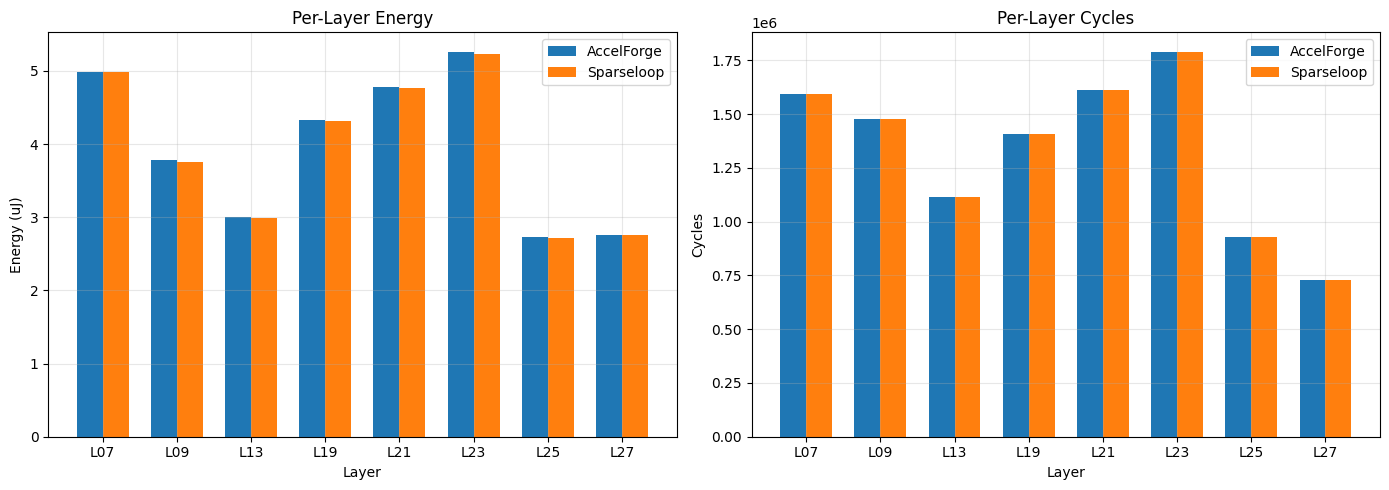

In [10]:
import matplotlib.pyplot as plt
import numpy as np

layer_names = [n for n in LAYERS if results.get(n) is not None]
af_energy = [results[n]['energy_uJ'] for n in layer_names]
sl_energy = [SL_GROUND_TRUTH[n]['energy_pJ'] / 1e6 for n in layer_names]

x = np.arange(len(layer_names))
width = 0.35

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Energy comparison
ax1.bar(x - width/2, af_energy, width, label='AccelForge', color='tab:blue')
ax1.bar(x + width/2, sl_energy, width, label='Sparseloop', color='tab:orange')
ax1.set_xlabel('Layer')
ax1.set_ylabel('Energy (uJ)')
ax1.set_title('Per-Layer Energy')
ax1.set_xticks(x)
ax1.set_xticklabels(layer_names)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Cycles comparison
af_cycles = [results[n]['cycles'] for n in layer_names]
sl_cycles = [SL_GROUND_TRUTH[n]['cycles'] for n in layer_names]

ax2.bar(x - width/2, af_cycles, width, label='AccelForge', color='tab:blue')
ax2.bar(x + width/2, sl_cycles, width, label='Sparseloop', color='tab:orange')
ax2.set_xlabel('Layer')
ax2.set_ylabel('Cycles')
ax2.set_title('Per-Layer Cycles')
ax2.set_xticks(x)
ax2.set_xticklabels(layer_names)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Results Summary

### Total Energy and Cycles (all 8 layers)

| Metric | Range | Notes |
|--------|-------|-------|
| **Energy** | -0.2% to +0.6% | All layers within 0.6% of Sparseloop |
| **Cycles** | -0.0% | Near-perfect match across all layers |

### L07 Per-Component Accuracy

L07 is the reference layer with verified Sparseloop per-component energy from stats files.

| Component | Delta | Notes |
|-----------|-------|-------|
| weight_spad | -0.0% | Per-element packing matches SL |
| reg | -0.0% | metadata_storage_width=4 from arch |
| iact_spad | +0.3% | UOP trivial dim fix (R=1) |
| psum_spad | -1.8% | SL uses data-delta-dependent ERT |
| MAC | +2.2% | Format-eliminated iterations counted as skipped |
| **Total** | **-0.02%** | |

### Key Fixes Applied (Phase 16)

1. **metadata_storage_width from arch**: Falls back to `metadata_read` action's
   `bits_per_action` (4 for iact_spad/reg, 8 for weight_spad) when sparse YAML
   doesn't specify it. Previously defaulted to data read width, over-counting metadata.

2. **Per-element packing**: SRAM words pack whole elements, not bit-streams.
   `ceil(count / floor(msw / word_bits))` instead of `ceil(total_bits / msw)`.
   Critical for UOP 7-bit payload in 8-bit SRAM (589,824 vs 516,096 words).

3. **UOP trivial dimension**: `fiber_shape <= 1` (e.g. R=1) produces 0 payload.
   Sparseloop reports 0 accesses for UOP on trivial ranks.

### Known Remaining Model Differences

1. **psum_spad ERT** (~1.8%): Sparseloop uses (addr_delta, data_delta)-dependent
   energy. AccelForge uses single average value (0.33633 pJ).

2. **MAC compute classification** (~2.2%): AccelForge counts format-eliminated
   iterations as `skipped_compute` (0.01798 pJ each). Sparseloop may classify
   some as zero-energy.

3. **Cycle rounding** (<0.03%): Hypergeometric probability rounding differences.